<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/L26-Node2Vec-Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Node2Vec with Pytorch 🔥

### Install Pytorch and import packages

In [ ]:
#import torch
#!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

In [39]:
!pip install torch-geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install pyg_lib --no-index -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html


In [41]:
import torch

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(torch.__version__)

2.6.0+cu124


In [46]:
import os.path as osp
import sys
import pandas as pd
import numpy as np
import networkx as nx
from random import randint

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

%matplotlib inline

### Load dataset

[The Cora dataset](https://ojs.aaai.org/aimagazine/index.php/aimagazine/article/view/2157) introduced by Sen et al. in 2008, Cora (no license) is the most popular dataset for node classification in the scientific literature. It represents a network of 2,708 publications, where each connection is a reference. Each publication is described as a binary vector of 1,433 unique words, where 0 and 1 indicate the absence or presence of the corresponding word, respectively. This representation is also called a binary bag of words in natural language processing. Our goal is to classify each node into one of seven categories.

Regardless of the type of data, visualization is always an important step to getting a good grasp of the problem we face. However, graphs can quickly become too big to visualize using Python libraries such as networkx. This is why dedicated tools have been developed specifically for graph data visualization. We utilize two of the most popular ones: yEd Live (https://www.yworks.com/yed-live/) and Gephi (https://gephi.org/).

The following figure is a plot of the Cora dataset made with yEd Live. You can see nodes corresponding to papers in orange and connections between them in green. Some papers are so interconnected that they form clusters. These clusters should be easier to classify than poorly connected nodes.

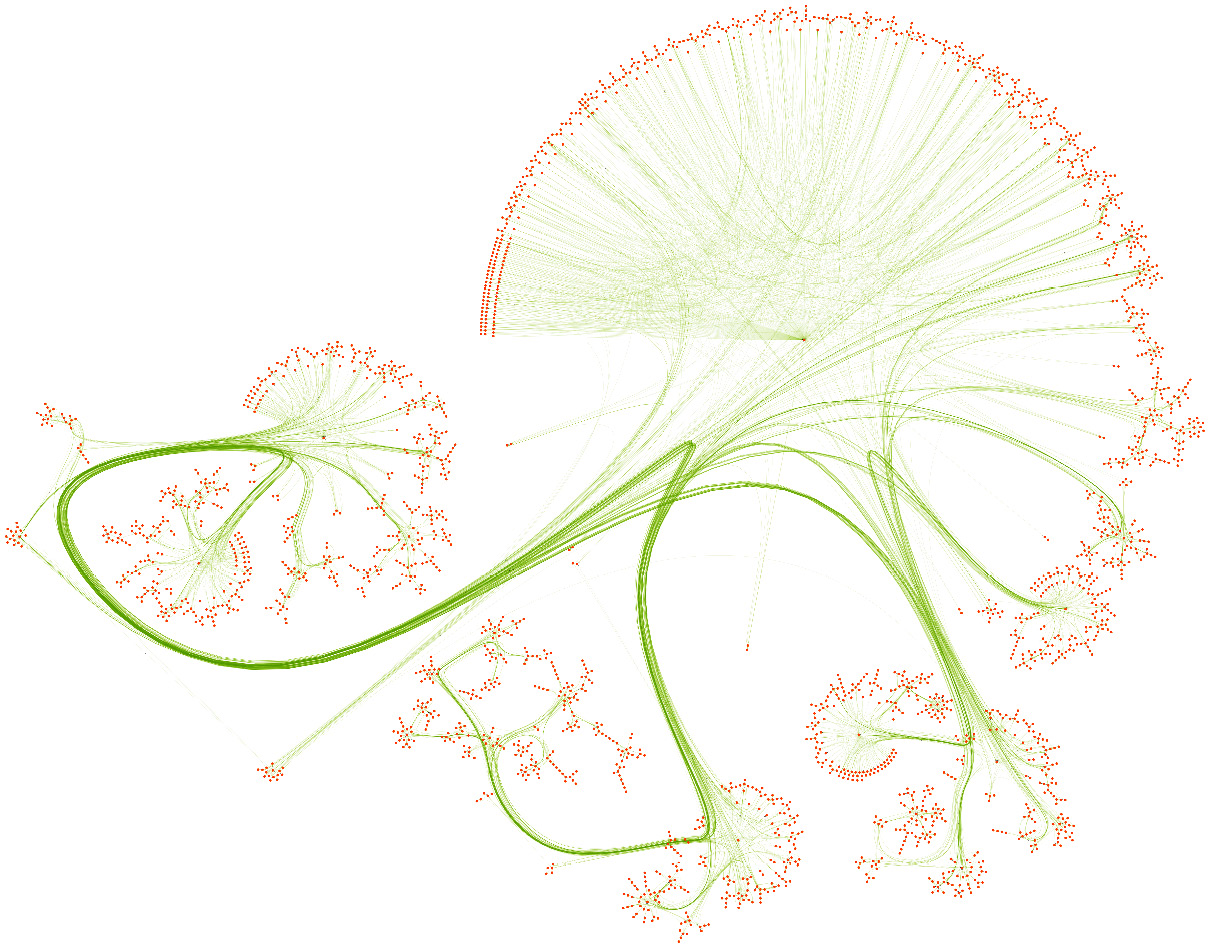

In [43]:
# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('---------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Cora()
---------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [ ]:
# Tensor with graph links
data.edge_index

tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

In [ ]:
# Tensor to Numpy array
data.edge_index.numpy()

array([[ 633, 1862, 2582, ...,  598, 1473, 2706],
       [   0,    0,    0, ..., 2707, 2707, 2707]])

In [ ]:
# Numpy aray to Pandas DataFrame
pd.DataFrame(data.edge_index.numpy())

0      1      2      3      4      5      6      7      8      9      ...  \
0    633   1862   2582      2    652    654      1    332   1454   1666  ...   
1      0      0      0      1      1      1      2      2      2      2  ...   

   10546  10547  10548  10549  10550  10551  10552  10553  10554  10555  
0    641    287    165    169   1473   2707    165    598   1473   2706  
1   2704   2705   2706   2706   2706   2706   2707   2707   2707   2707  

[2 rows x 10556 columns]

In [ ]:
# Full graph links transformation from Tensor to DataFrame
pd.DataFrame(data.edge_index.numpy().T, columns=['start_node', 'end_node'])

start_node  end_node
0             633         0
1            1862         0
2            2582         0
3               2         1
4             652         1
...           ...       ...
10551        2707      2706
10552         165      2707
10553         598      2707
10554        1473      2707
10555        2706      2707

[10556 rows x 2 columns]

## Visualizing the graph

In [47]:
edge_index_list = pd.DataFrame(data.edge_index.numpy().T, columns=['start_node','end_node'])

In [48]:
G = nx.from_pandas_edgelist(edge_index_list, "start_node", "end_node")

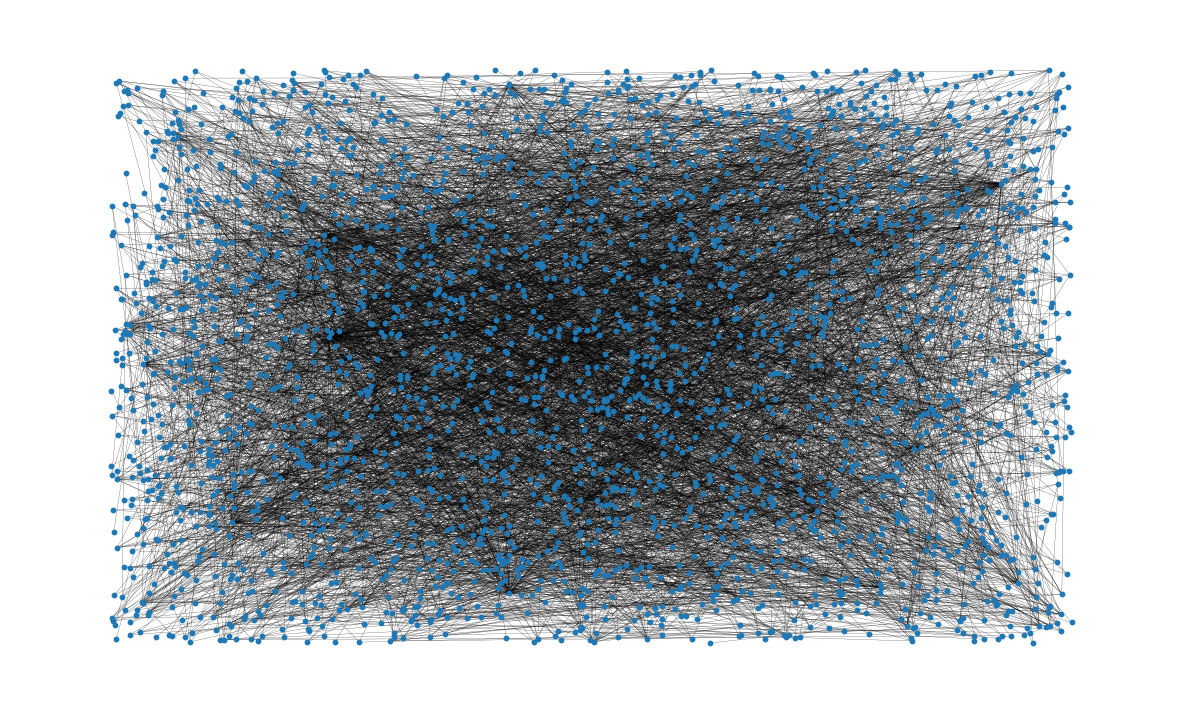

In [49]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

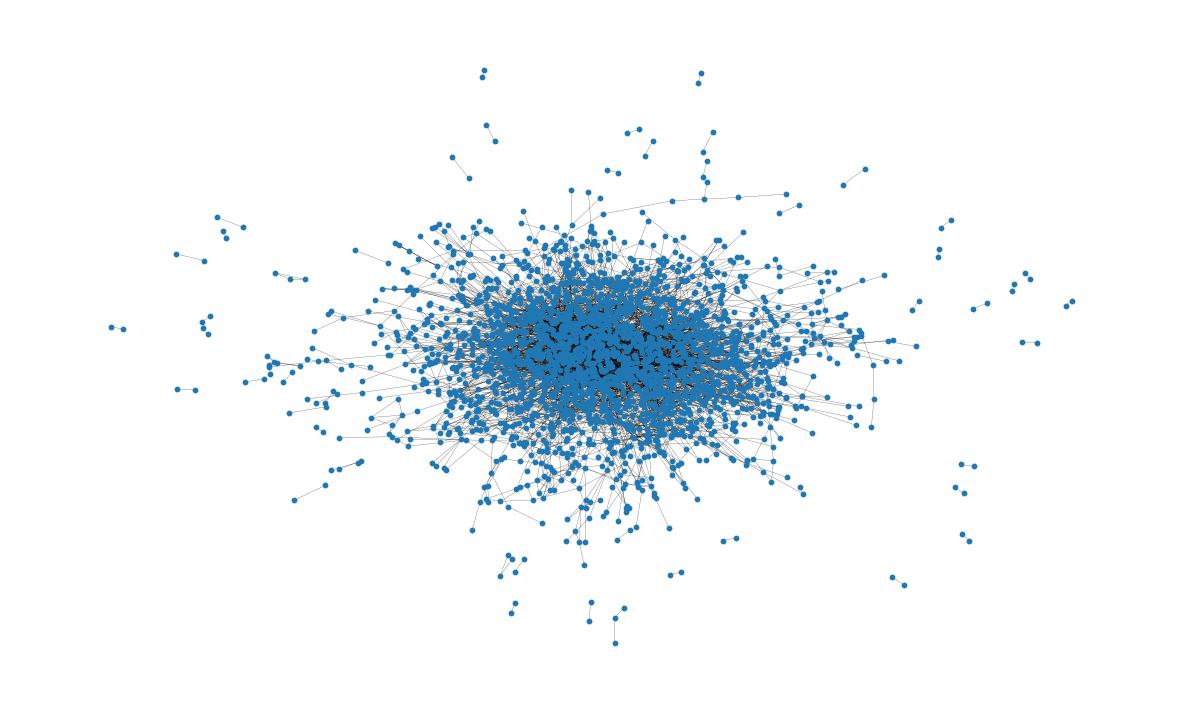

In [50]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

In [51]:
# Filtering at least three connections
edge_index_list_filtered = edge_index_list.groupby("start_node").filter(lambda x: len(x) > 3)
edge_index_list_filtered.head()

start_node  end_node
1         1862         0
3            2         1
7          332         2
9         1666         2
10        1986         2

In [52]:
G = nx.from_pandas_edgelist(edge_index_list_filtered, "start_node", "end_node")

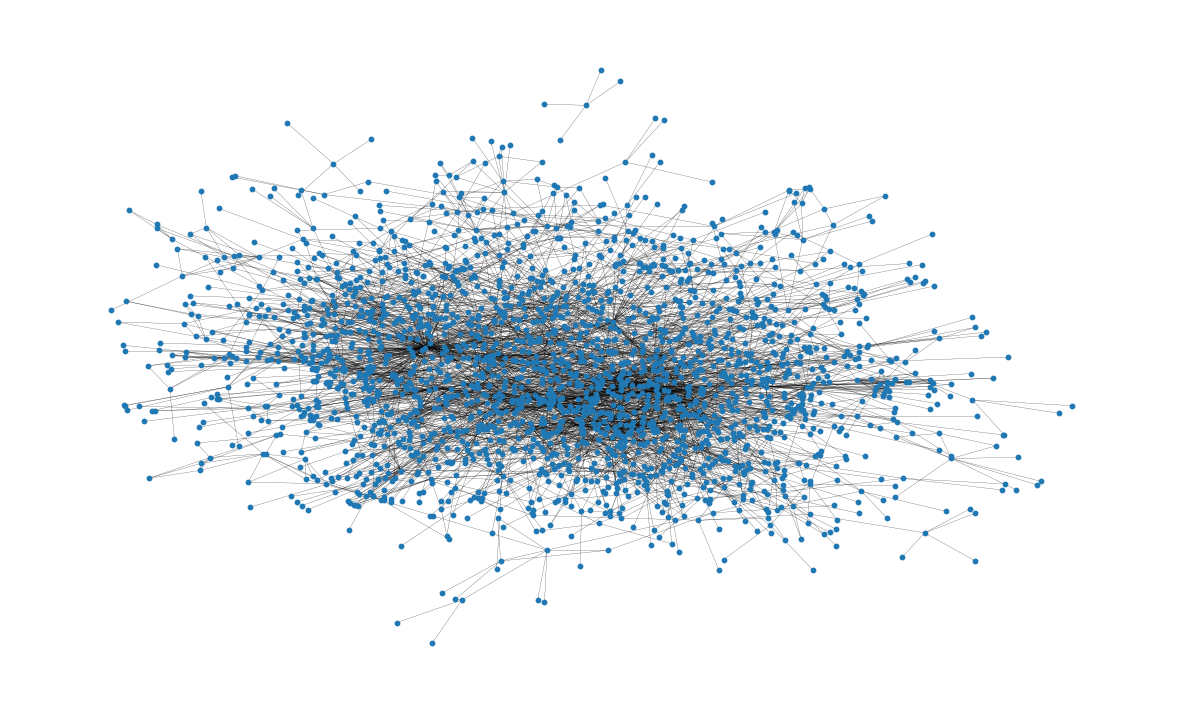

In [53]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

## Node2Vec Model

In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [55]:
# Declare model
model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0,
    sparse=True,
).to(device)

In [56]:
num_workers = 2 if sys.platform == 'linux' else 0
loader = model.loader(batch_size=128, shuffle=True, num_workers=num_workers) # this needed to calculate loss funtion (positive random walks and negative random walks)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [57]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [58]:
@torch.no_grad() # -> Context-manager that disables gradient calculation. Computational cost and efficiency
def test():
    model.eval()
    z = model()
    acc = model.test(
        train_z=z[data.train_mask],
        train_y=data.y[data.train_mask],
        test_z=z[data.test_mask],
        test_y=data.y[data.test_mask],
        max_iter=150,
    )
    return acc

In [59]:
for epoch in range(1, 101):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

Epoch: 001, Loss: 8.0347, Acc: 0.1810
Epoch: 002, Loss: 6.0324, Acc: 0.2030
Epoch: 003, Loss: 4.9275, Acc: 0.2170
Epoch: 004, Loss: 4.0896, Acc: 0.2620
Epoch: 005, Loss: 3.4456, Acc: 0.2970
Epoch: 006, Loss: 2.9256, Acc: 0.3320
Epoch: 007, Loss: 2.5116, Acc: 0.3660
Epoch: 008, Loss: 2.1829, Acc: 0.3960
Epoch: 009, Loss: 1.9284, Acc: 0.4140
Epoch: 010, Loss: 1.7168, Acc: 0.4410
Epoch: 011, Loss: 1.5452, Acc: 0.4690
Epoch: 012, Loss: 1.4083, Acc: 0.4940
Epoch: 013, Loss: 1.3004, Acc: 0.5260
Epoch: 014, Loss: 1.2141, Acc: 0.5540
Epoch: 015, Loss: 1.1463, Acc: 0.5790
Epoch: 016, Loss: 1.0902, Acc: 0.6020
Epoch: 017, Loss: 1.0492, Acc: 0.6200
Epoch: 018, Loss: 1.0131, Acc: 0.6250
Epoch: 019, Loss: 0.9860, Acc: 0.6270
Epoch: 020, Loss: 0.9658, Acc: 0.6410
Epoch: 021, Loss: 0.9439, Acc: 0.6410
Epoch: 022, Loss: 0.9311, Acc: 0.6490
Epoch: 023, Loss: 0.9167, Acc: 0.6560
Epoch: 024, Loss: 0.9057, Acc: 0.6640
Epoch: 025, Loss: 0.8963, Acc: 0.6620
Epoch: 026, Loss: 0.8904, Acc: 0.6700
Epoch: 027, 

In [60]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    y = data.y.cpu().numpy()

    plt.figure(figsize=(15, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

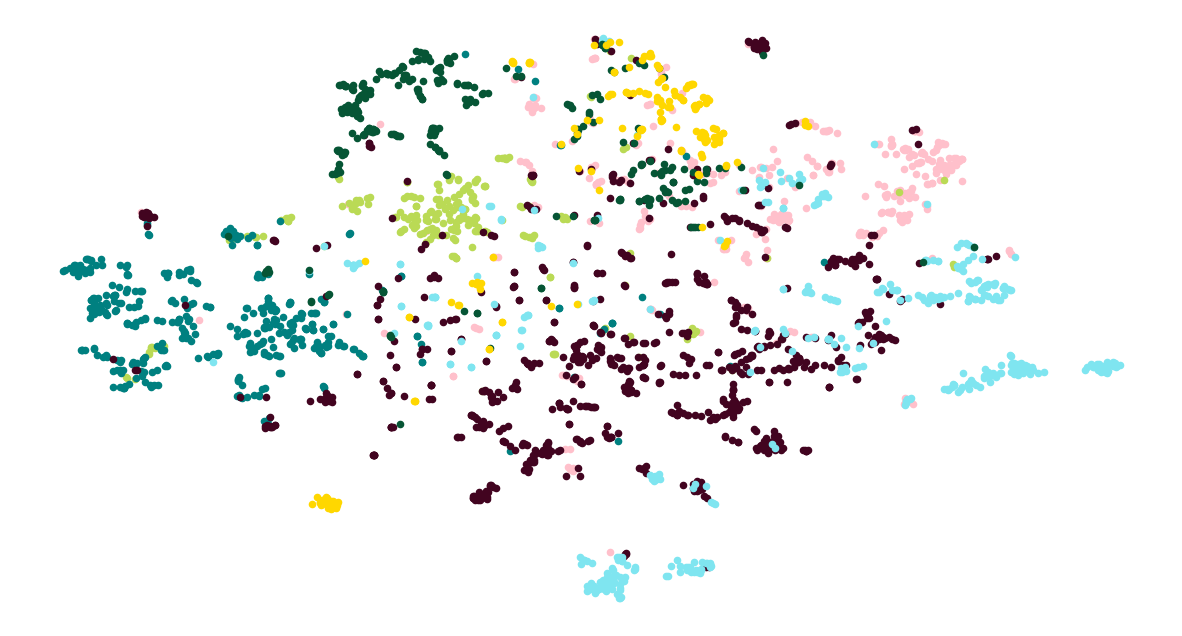

In [61]:
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)